# Hackingforfuture Task 4 - Predictive Quality Data Analysis

some details on this hackathon... To be filled during the presentation phase.

# Import Libs

In [60]:
import numpy as np
import pandas as pd
import feature_engine as fe

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from feature_engine.categorical_encoders import OneHotCategoricalEncoder


import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(48)

# Loading file
The file in our case is transformed into csv-file.

In [61]:
filename = 'csvdata.csv'
df = pd.read_csv(filename)
df.head()

,Time,Date,asm_Force #D,asm_Length #E,asm_Height #F,asm_Press-fit #G,asm_force #H,asm_Length #I,asm_Depth #J,asm_depth #K,...,"fin_Tracking, Zone3 #BU","fin_Tracking, Zone4 #BV","fin_Tracking, Zone1, G #BW","fin_Tracking, Zone2, G #BX","fin_Tracking, Zone3, G #BY","fin_Tracking, Zone4, G #BZ",fin_Shape #CA,fin_pressure #CB,fin_flow #CC,fin_temperature #CD
0,02:02:09,03.01.18,0.149,102.52,0.215,12.747,1.094,135.43,1.8541,1.8517,...,96000.0,139700.0,0.14,0.12,0.07,0.08,V-shape,2.915,0.828,88.15
1,02:02:41,03.01.18,0.163,102.61,0.191,12.731,1.116,135.48,1.8583,1.8556,...,97800.0,138100.0,0.16,0.14,0.06,0.12,V-shape,2.933,1.068,89.14
2,02:05:06,03.01.18,0.160,102.56,0.192,12.734,1.033,135.48,1.8533,1.8487,...,112100.0,140000.0,0.04,0.03,0.02,0.15,V-shape,2.916,0.828,87.30
3,02:05:31,03.01.18,0.158,102.47,0.195,12.726,1.079,135.48,1.8578,1.8546,...,96000.0,140000.0,0.25,0.20,0.07,0.18,Ascending,2.925,1.068,88.68
4,02:08:00,03.01.18,0.154,102.61,0.207,12.752,1.061,135.48,1.8594,1.8543,...,100500.0,137700.0,0.14,0.13,0.10,0.23,Ascending,2.904,0.816,87.29


## Distinguish columns
Due to my laziness to join data table, I created one universal dataframe with prepended column names: `asm_`, `int_`, and `fin_` which stand for assembly data, initial inspection data, and final inspection data respectively.

In [62]:
cols = df.columns.tolist()
# remove # from column names
for idc, c in enumerate(cols):
    for idx, char in enumerate(c):
        if char == '#':
            break
    cols[idc] = c[:idx-1]
cols

['Ti',
 'Da',
 'asm_Force',
 'asm_Length',
 'asm_Height',
 'asm_Press-fit',
 'asm_force',
 'asm_Length',
 'asm_Depth',
 'asm_depth',
 'asm_Depth',
 'asm_parallelism',
 'asm_force',
 'asm_Length',
 'asm_force',
 'asm_Length',
 'asm_torque 1',
 'asm_angle 1',
 'asm_torque 2',
 'asm_angle 2',
 'asm_torque 3',
 'asm_angle 3',
 'asm_torque 1',
 'asm_torque 2',
 'asm_torque 3',
 'asm_angle 1',
 'asm_angle 2',
 'asm_angle 3',
 'asm_torque 1',
 'asm_torque 2',
 'asm_torque 3',
 'asm_torque 4',
 'asm_angle 1',
 'asm_angle 2',
 'asm_angle 3',
 'asm_angle 4',
 'asm_temperature',
 'asm_force',
 'asm_Length',
 'asm_force',
 'asm_Temperature',
 'asm_angle',
 'asm_torque',
 'asm_angle',
 'asm_torque',
 'asm_clearance',
 'int_weight',
 'int_Angle position ',
 'int_weight',
 'int_Angle position',
 'int_Tracking, Zone1',
 'int_Tracking, Zone2',
 'int_Tracking, Zone3',
 'int_Tracking, Zone4',
 'int_Tracking, Zone1, G',
 'int_Tracking, Zone2, G',
 'int_Tracking, Zone3, G',
 'int_Tracking, Zone4, G',
 'int

In [63]:
def redefine_cols(cols):
    cols_asm = [c for c in cols if 'asm_' == c[:4]]
    cols_int = [c for c in cols if 'int_' == c[:4]]
    cols_fin = [c for c in cols if 'fin_' == c[:4]]
    return cols_asm, cols_int, cols_fin
cols_asm, cols_int, cols_fin = redefine_cols(cols)
print("Assembly data columns: {}".format(len(cols_asm)))
print("Initial inspection data columns: {}".format(len(cols_int)))
print("Final inspection data columns: {}".format(len(cols_fin)))

Assembly data columns: 44
Initial inspection data columns: 16
Final inspection data columns: 16


In [64]:
df.columns = cols

# Exploratory Data Analysis
This part involves EDA process. The first step is to find Nan.

In [65]:
# Find Nan
df.isnull().mean()

Ti                        0.000000
Da                        0.000000
asm_Force                 0.000000
asm_Length                0.000000
asm_Height                0.000000
                            ...   
fin_Tracking, Zone4, G    0.042976
fin_Shape                 0.042976
fin_pressure              0.042976
fin_flow                  0.042976
fin_temperature           0.042976
Length: 78, dtype: float64

There are around 5% of Nan in this data set. From the readme file, this is due to quality stuffs or whatever. The Nan are only in the final inspection.

In [66]:
# Check data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16963 entries, 0 to 16962
Data columns (total 78 columns):
Ti                        16963 non-null object
Da                        16963 non-null object
asm_Force                 16963 non-null float64
asm_Length                16963 non-null float64
asm_Height                16963 non-null float64
asm_Press-fit             16963 non-null float64
asm_force                 16963 non-null float64
asm_Length                16963 non-null float64
asm_Depth                 16963 non-null float64
asm_depth                 16963 non-null float64
asm_Depth                 16963 non-null float64
asm_parallelism           16963 non-null float64
asm_force                 16963 non-null float64
asm_Length                16963 non-null float64
asm_force                 16963 non-null float64
asm_Length                16963 non-null float64
asm_torque 1              16963 non-null float64
asm_angle 1               16963 non-null float64
asm_torque 

Most of the data are number variables. There are `Da`, `Ti`, `int_Shape`, and `fin_Shape` which are categorical variables. These variables shall be encoded afterwards.

In [67]:
# After this point will be data processing. The initial dataframe shall be backed up first.
df_bkup = df

# Nan processing
This section dedicates for Nan processing. The quick-dirty process is to remove the Nan out. If there is time left, data imputation can be done.

In [68]:
# remove nan
df = df.dropna()
df.isnull().mean()

Ti                        0.0
Da                        0.0
asm_Force                 0.0
asm_Length                0.0
asm_Height                0.0
                         ... 
fin_Tracking, Zone4, G    0.0
fin_Shape                 0.0
fin_pressure              0.0
fin_flow                  0.0
fin_temperature           0.0
Length: 78, dtype: float64

# Start Pipeline

In [99]:
label_col = 'fin_temperature'

if 'Da' in df.columns:
    df.drop(columns=['Da', 'Ti'], inplace=True)
features_numerical = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
features_categorical = df.select_dtypes(include=['object']).columns.tolist()

if label_col in features_categorical:
    features_categorical.remove(label_col)
if label_col in features_numerical:
    features_numerical.remove(label_col)
df[features_categorical].head()

,int_Shape,fin_Shape
0,Ascending,V-shape
1,V-shape,V-shape
2,V-shape,V-shape
3,V-shape,Ascending
4,Descending,Ascending


In [100]:
df[features_numerical].head()

,asm_Force,asm_Length,asm_Length,asm_Length,asm_Length,asm_Length,asm_Height,asm_Press-fit,asm_force,asm_force,...,"fin_Tracking, Zoe1","fin_Tracking, Zone2","fin_Tracking, Zone3","fin_Tracking, Zone4","fin_Tracking, Zone1, G","fin_Tracking, Zone2, G","fin_Tracking, Zone3, G","fin_Tracking, Zone4, G",fin_pressure,fin_flow
0,0.149,102.52,135.43,89.25,149.25,120.00,0.215,12.747,1.094,0.00747,...,54700.0,66200.0,96000.0,139700.0,0.14,0.12,0.07,0.08,2.915,0.828
1,0.163,102.61,135.48,89.27,149.28,120.00,0.191,12.731,1.116,0.00692,...,52100.0,66700.0,97800.0,138100.0,0.16,0.14,0.06,0.12,2.933,1.068
2,0.160,102.56,135.48,89.28,149.27,120.05,0.192,12.734,1.033,0.00687,...,50900.0,65000.0,112100.0,140000.0,0.04,0.03,0.02,0.15,2.916,0.828
3,0.158,102.47,135.48,89.28,149.28,120.05,0.195,12.726,1.079,0.00788,...,51400.0,65000.0,96000.0,140000.0,0.25,0.20,0.07,0.18,2.925,1.068
4,0.154,102.61,135.48,89.28,149.28,119.96,0.207,12.752,1.061,0.00688,...,55100.0,67400.0,100500.0,137700.0,0.14,0.13,0.10,0.23,2.904,0.816


# Train-test split
Do `train_test_split` here to avoid information leakage. But first of all the label columns should be identified.

In [101]:
# This train_test_split is done under an assumption that the sequence does not matter.
# There will be another analysis that consider the sequence of data.


# X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Da', 'Ti']+label_cols), 
#                                                     df[label_cols], 
#                                                     test_size=0.3, shuffle=False)

# This split considers sequence. 
nrows = df.shape[0]
test_size = int(0.3*nrows)

train = df.head(nrows-test_size)
test = df.tail(test_size)

df.shape, train.shape, test.shape


((16234, 76), (11364, 76), (4870, 76))

In [116]:
def transform_label(data, label_col, ok_std=1.5):
    label_mean = data[label_col].mean()
    label_std = data[label_col].std()
    data['label'] = (np.abs(data[label_col] - label_mean) < ok_std*label_std)*1
    return data
train = transform_label(train, label_col, ok_std=1.5)
test = transform_label(test, label_col, ok_std=1.5)
  

/Users/peerapon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [122]:
X_train = train.drop(columns=[label_col]+['label'])
y_train = train['label']
X_test = test.drop(columns=[label_col]+['label'])
y_test = test['label'] 

# Transform data

In [123]:
from sklearn.ensemble import RandomForestClassifier
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])
catergorical_transformer = Pipeline(steps=[
    ('onehot', OneHotCategoricalEncoder(
                top_categories=None,
                variables = features_categorical,
                drop_last=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, features_numerical),
        ('cat', catergorical_transformer, features_categorical)
    ]
    )
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

In [124]:
y_train

0        1
1        1
2        1
3        1
4        1
        ..
11895    1
11896    1
11897    1
11898    1
11899    1
Name: label, Length: 11364, dtype: int64

# Modeing

In [125]:
param_grid = {"classifier__max_depth": [3, None],
              "classifier__max_features": [1, 3, 10],
              "classifier__min_samples_split": [2, 3, 10]}
grid_search = GridSearchCV(clf, param_grid, cv=5, iid=False, scoring='accuracy')


In [126]:
grid_search.fit(X_train, y_train)


/Users/peerapon/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/peerapon/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/peerapon/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/peerapon/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/peerapon/opt/anaconda3/lib/python3.7/

/Users/peerapon/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/peerapon/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/peerapon/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/peerapon/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/peerapon/opt/anaconda3/lib/python3.7/

/Users/peerapon/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/peerapon/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/peerapon/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/peerapon/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/peerapon/opt/anaconda3/lib/python3.7/

/Users/peerapon/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/peerapon/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/peerapon/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/peerapon/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/peerapon/opt/anaconda3/lib/python3.7/

/Users/peerapon/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/peerapon/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/peerapon/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/peerapon/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/peerapon/opt/anaconda3/lib/python3.7/

/Users/peerapon/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/peerapon/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1)))]), ['asm_Force', 'asm_Length', 'asm_Height', 'a...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'classifier__max_depth': [3, None], 'classifier__max_features': [1, 3, 10], 'classifier__min_samples_split': [2, 3, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [127]:
best = grid_search.best_estimator_
y_pred = best.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

Confusion matrix, without normalization
[[ 113  381]
 [  32 4344]]


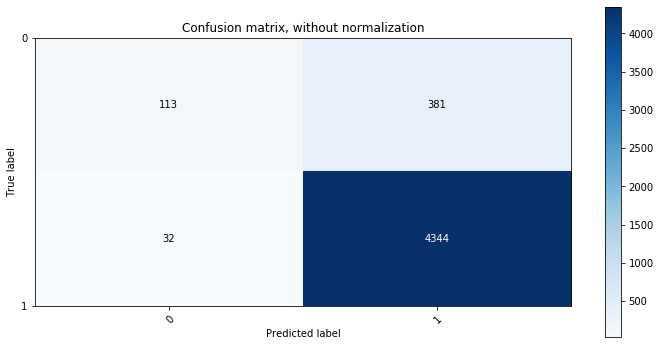

In [128]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, 0.5*i+0.25, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
plot_confusion_matrix(y_test, y_pred, classes=['outTol', 'inTol'],
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.22874494 0.77125506]
 [0.00731261 0.99268739]]


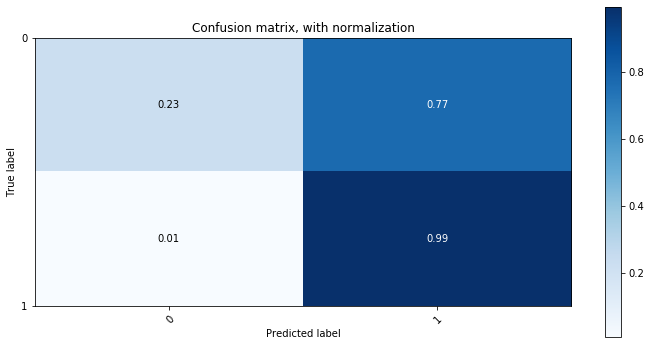

In [130]:
plot_confusion_matrix(y_test, y_pred, classes=[0,1], normalize=True,
                      title='Confusion matrix, with normalization')